In [941]:
import sys
sys.path.insert(0, '../../Utilities/')
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(1234)
torch.manual_seed(1234)

class PhysicsInformedNN(nn.Module):
#     def __init__(self, layers):
    def __init__(self, layers):
        super(PhysicsInformedNN, self).__init__()
        
        self.nn = nn.Sequential()
        for l in range(len(layers)-2):
            self.nn.add_module('linear'+str(l), nn.Linear(layers[l], layers[l+1]))
            self.nn.add_module('tanh'+str(l), nn.Tanh())
        self.nn.add_module('linear_last', nn.Linear(layers[-2], layers[-1]) )
#         self.layers = layers
#         self.init_NN(layers) # 构建网络
        
#     def init_NN(self, layers):
#         self.nn = nn.ModuleList([nn.Linear(layers[l], layers[l+1]) 
#                                  for l in range(len(layers)-1) ] )        
        
    def forward(self, x):
        out = self.nn(x)
#         for layer in self.nn[:-1] :
#             x = torch.tanh(layer(x))
#         x = self.nn[-1](x)
        return out

# model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

In [943]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('../Data/burgers_shock.mat')

#转成一列
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t) # X与T的维数为n_t*n_x 第一维是时间

# X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
X_star = np.stack((X.ravel(), T.ravel()), axis=1)
u_star = Exact.ravel()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)
#初值
xx1 = np.stack((X[0,:], T[0,:]), axis=1) #xx1中坐标（x,t）
uu1 = Exact[0:1,:].T #确保是一列
#左边界
xx2 = np.stack((X[:,0], T[:,0]), axis=1)
uu2 = Exact[:,0:1]
#右边界
xx3 = np.stack((X[:,-1], T[:,-1]), axis=1)
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
u_train = np.vstack([uu1, uu2, uu3])
X_f_train = lb + (ub-lb)*lhs(2, N_f) # 用lhs在区域内生成N_f个点
X_f_train = np.vstack((X_f_train, X_u_train))
#random 选 N_u 个点作为 u 训练集
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

device = torch.device('cuda')
X_u_trainG = torch.tensor(X_u_train, dtype=torch.float, device=device)
u_trainG = torch.tensor(u_train,dtype=torch.float,device=device)
X_f_trainG = torch.tensor(X_f_train,dtype=torch.float,device=device)


In [944]:
model = PhysicsInformedNN(layers)
model.to(device=device)

PhysicsInformedNN(
  (nn): Sequential(
    (linear0): Linear(in_features=2, out_features=20, bias=True)
    (tanh0): Tanh()
    (linear1): Linear(in_features=20, out_features=20, bias=True)
    (tanh1): Tanh()
    (linear2): Linear(in_features=20, out_features=20, bias=True)
    (tanh2): Tanh()
    (linear3): Linear(in_features=20, out_features=20, bias=True)
    (tanh3): Tanh()
    (linear4): Linear(in_features=20, out_features=20, bias=True)
    (tanh4): Tanh()
    (linear5): Linear(in_features=20, out_features=20, bias=True)
    (tanh5): Tanh()
    (linear6): Linear(in_features=20, out_features=20, bias=True)
    (tanh6): Tanh()
    (linear7): Linear(in_features=20, out_features=20, bias=True)
    (tanh7): Tanh()
    (linear_last): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [937]:
for i in model.children():
    for j in i:
        if type(j) == nn.Linear:
            print(j)
            torch.nn.init.xavier_normal_(j.weight)
            torch.nn.init.zeros_(j.bias)
#             print(j.weight)
        

Linear(in_features=2, out_features=20, bias=True)
Linear(in_features=20, out_features=20, bias=True)
Linear(in_features=20, out_features=20, bias=True)
Linear(in_features=20, out_features=20, bias=True)
Linear(in_features=20, out_features=20, bias=True)
Linear(in_features=20, out_features=20, bias=True)
Linear(in_features=20, out_features=20, bias=True)
Linear(in_features=20, out_features=20, bias=True)
Linear(in_features=20, out_features=1, bias=True)


In [949]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_func = torch.nn.MSELoss()

grad_weight = torch.ones((X_f_trainG.shape[0] , 1)).to(device)
grad_weight2 = torch.zeros_like(X_f_trainG).to(device) 
grad_weight2[:,0] = 1. #第一列为1
target_f = torch.zeros((X_f_train.shape[0] , 1)).to(device)
X_f_trainG.requires_grad_()

for epoch in range(1000):
    u_pred = model(X_u_trainG)
    u_f_pred = model(X_f_trainG)
           
    u_f_pred_grad = torch.autograd.grad(u_f_pred, X_f_trainG, 
                                     grad_weight, create_graph=True, retain_graph=True)[0]
    u_f_pred_grad2 = torch.autograd.grad(u_f_pred_grad, X_f_trainG,
                                     grad_weight2, create_graph=True, retain_graph=True)[0]
    
#     for i in model.children():
#         for j in i:
#             if type(j) == nn.Linear:
#                 print(j)
# #                 torch.nn.init.xavier_normal_(j.weight)
# #                 torch.nn.init.zeros_(j.bias)
#                 print(j.bias)
    
    u_f_pred_t = u_f_pred_grad[:, 1:2] # u_t 在第二列
    u_f_pred_x = u_f_pred_grad[:, 0:1]
    u_f_pred_xx = u_f_pred_grad2[:,0:1]
    #f = u_t + u*u_x - self.nu*u_xx
    f_pred = u_f_pred_t + u_f_pred*u_f_pred_x - nu*u_f_pred_xx
    
    loss_u = loss_func(u_pred, u_trainG)
    loss_f = loss_func(f_pred, target_f)
    loss = loss_u + loss_f

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1)%100==0:
        print('loss: ', loss.item(), 'loss_u: ', loss_u.item(),'loss_f: ', loss_f.item())



loss:  0.31987911462783813 loss_u:  0.31987911462783813 loss_f:  5.221391353137095e-13
loss:  0.3198789954185486 loss_u:  0.3198789954185486 loss_f:  1.1350692521311379e-12
loss:  0.31987878680229187 loss_u:  0.31987878680229187 loss_f:  2.7253371000929283e-12
loss:  0.3198784291744232 loss_u:  0.3198784291744232 loss_f:  7.893408149328707e-12
loss:  0.3198769688606262 loss_u:  0.3198769688606262 loss_f:  4.1474074174985276e-11
loss:  0.31800052523612976 loss_u:  0.317970871925354 loss_f:  2.9655129765160382e-05
loss:  0.32003024220466614 loss_u:  0.32003024220466614 loss_f:  4.820621058308101e-34
loss:  0.3198794424533844 loss_u:  0.3198794424533844 loss_f:  4.819544287115649e-34
loss:  0.3198794722557068 loss_u:  0.3198794722557068 loss_f:  4.819554389020226e-34
loss:  0.3198794424533844 loss_u:  0.3198794424533844 loss_f:  4.819553011487784e-34


In [ ]:
x = torch.randn(1,2)
d= dict(model.named_parameters())
d['z']= X_f_trainG

make_dot(u_f_pred,d)

Text(0.5,1,'$t = 0.75$')

C:\Users\z\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


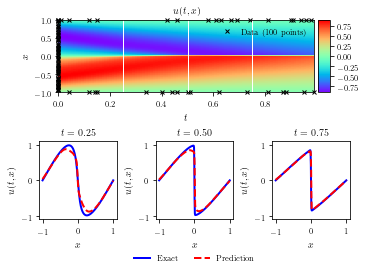

In [948]:
u_pred = model(torch.from_numpy(X_star).float().to(device))

# error_u = torch.norm(u_star-u_pred,2)/torch.norm(u_star,2)
# print('Error u: %e' % (error_u))

u_pred = u_pred.detach().cpu().numpy()
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)


######################################################################
############################# Plotting ###############################
######################################################################    

fig, ax = newfig(1.0, 1.1)
ax.axis('off')

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)